<br></br>
<h1><center>Assignment 06</h1></center>
<h1><center>Model selection</h1></center>
<h2><center>Benedek Dankó</h2></center>

In [2]:
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib_venn import venn3
from mpl_toolkits.mplot3d import Axes3D

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### 1. Implement a linear model

In [3]:
# generate a regression model:
X, Y, coef = make_regression(n_samples=1000, n_features=20, random_state=11, coef = True)

In [4]:
coef # these are the coefficients

array([42.08705876,  0.        , 47.47678349, 78.00718518, 93.41570284,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       38.85188486, 46.39425509, 39.65498672, 32.94737409,  0.        ,
       66.70338827,  0.        , 85.52611926,  0.        ,  0.        ])

x5, x18, x4 variables have the highest weight, they influence the most the response (Y) variable.

In [5]:
# get the intercept:
Y[0] - sum(np.multiply(X[0], coef))

1.4210854715202004e-14

The intercept is actually ~ 0, which means that probably it is subtracted by default (?).

In [8]:
# Linear regression model:
model = LinearRegression().fit(X, Y)
model.score(X, Y) # perfect fit to the data points

1.0

In [9]:
# coefficients of the Linear Regression model:
model.coef_

array([ 4.20870588e+01, -2.13162821e-14,  4.74767835e+01,  7.80071852e+01,
        9.34157028e+01, -5.77315973e-15,  1.77635684e-14, -8.17124146e-14,
       -3.51940699e-14, -4.61852778e-14,  3.88518849e+01,  4.63942551e+01,
        3.96549867e+01,  3.29473741e+01,  3.67345043e-14,  6.67033883e+01,
        7.81597009e-14,  8.55261193e+01, -5.95079541e-14, -1.77635684e-15])

In [10]:
# Difference between the make_regression coefficients and the LinearRegression coefficients:
model.coef_ - coef

array([ 2.13162821e-14, -2.13162821e-14, -7.10542736e-14,  2.84217094e-14,
        2.98427949e-13, -5.77315973e-15,  1.77635684e-14, -8.17124146e-14,
       -3.51940699e-14, -4.61852778e-14, -1.06581410e-13,  0.00000000e+00,
       -3.55271368e-14, -7.10542736e-15,  3.67345043e-14, -9.94759830e-14,
        7.81597009e-14, -1.42108547e-14, -5.95079541e-14, -1.77635684e-15])

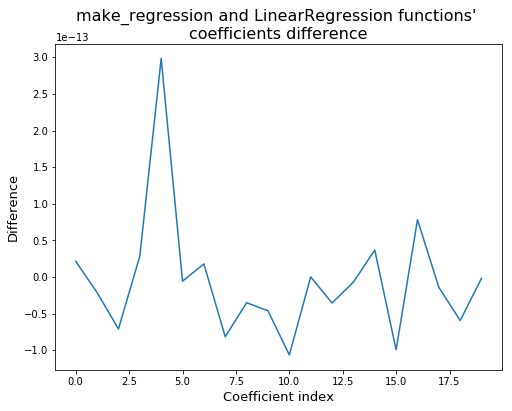

In [11]:
# plot the difference:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(model.coef_ - coef)
ax.axes.set_title("make_regression and LinearRegression functions' \ncoefficients difference",fontsize=16)
ax.set_xlabel("Coefficient index",fontsize=13)
ax.set_ylabel("Difference",fontsize=13)
plt.show()

### 2. Use of real data

In [12]:
# load and clean header data:
header = pd.read_csv('../data/communities.names', skiprows = 75, nrows=128, header=None)
header = [i.replace('@attribute ', '').replace(' numeric', '').replace(' string', '') for i in header[0].to_list()]

In [13]:
df = pd.read_csv('../data/communities.data', names=header, na_values='?')
df.drop(['state', 'county', 'community', 'communityname', 'fold'], axis=1, inplace=True)

In [14]:
df.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


In [15]:
df.describe()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
count,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,...,1994.000000,1994.000000,1994.000000,319.000000,319.000000,319.000000,319.000000,1994.000000,319.000000,1994.000000
mean,0.057593,0.463395,0.179629,0.753716,0.153681,0.144022,0.424218,0.493867,0.336264,0.423164,...,0.065231,0.232854,0.161685,0.163103,0.076708,0.698589,0.440439,0.094052,0.195078,0.237979
std,0.126906,0.163717,0.253442,0.244039,0.208877,0.232492,0.155196,0.143564,0.166505,0.179185,...,0.109459,0.203092,0.229055,0.214778,0.140207,0.213944,0.405808,0.240328,0.164718,0.232985
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.010000,0.350000,0.020000,0.630000,0.040000,0.010000,0.340000,0.410000,0.250000,0.300000,...,0.020000,0.100000,0.020000,0.040000,0.020000,0.620000,0.000000,0.000000,0.110000,0.070000
50%,0.020000,0.440000,0.060000,0.850000,0.070000,0.040000,0.400000,0.480000,0.290000,0.420000,...,0.040000,0.170000,0.070000,0.080000,0.030000,0.750000,0.500000,0.000000,0.150000,0.150000
75%,0.050000,0.540000,0.230000,0.940000,0.170000,0.160000,0.470000,0.540000,0.360000,0.530000,...,0.070000,0.280000,0.190000,0.195000,0.060000,0.840000,1.000000,0.000000,0.220000,0.330000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


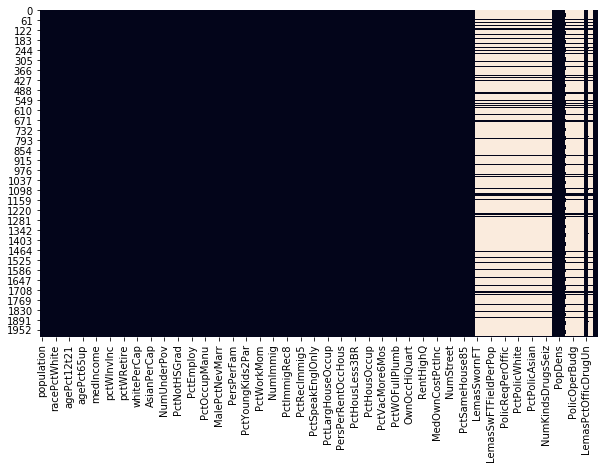

In [16]:
# Nan values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [17]:
# drop columns with too many Nans (threshold: number of rows/2):
df2 = df.dropna(thresh=len(df) - len(df)/2, axis=1)

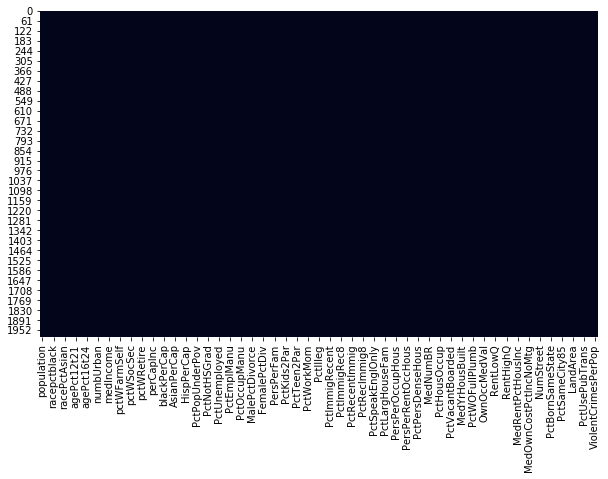

In [18]:
plt.figure(figsize=(10, 6))
sns.heatmap(df2.isnull(), cbar=False)
plt.show()

In [19]:
# fill up remaining NaNs with column means:
df2.fillna(df2.mean(), inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [20]:
X = np.asarray(df2.loc[:, df2.columns != 'ViolentCrimesPerPop']) # X matrix
Y = np.asarray(df2['ViolentCrimesPerPop']) # Y values

In [21]:
# KFold cross validation:
kf = KFold(n_splits=5, random_state=12)
clf = LinearRegression() # Linear Regression model

In [22]:
train_scores = []
test_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    clf.fit(X_train, y_train)
    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)
    train_scores.append(score_train)
    test_scores.append(score_test)
    print('Train score: {}, test score: {}'.format(score_train, score_test))
    
print('\nMean of training scores: {}, standard deviation of training scores: {}'.format(np.mean(train_scores), np.std(train_scores)))
print('Mean of test scores: {}, standard deviation of test scores: {}'.format(np.mean(test_scores), np.std(test_scores)))

Train score: 0.7096520049982642, test score: 0.6089030310185868
Train score: 0.7051438043147071, test score: 0.6309671585331147
Train score: 0.6831993074334818, test score: 0.7143120336435655
Train score: 0.6937242328253963, test score: 0.6684603015555026
Train score: 0.7040728815770063, test score: 0.6219128488869495

Mean of training scores: 0.6991584462297711, standard deviation of training scores: 0.009532216408143447
Mean of test scores: 0.648911074727544, standard deviation of test scores: 0.03823869659142788


Of course, the model performs better on the training dataset than on the test dataset (see mean scores), and similarly the SD is higher on the test set.

In [23]:
lasso = Lasso(random_state=0) # set up model
alphas = np.linspace(0.00001, 1, 100) # generate alpha values
max_iters = [1000, 2000, 5000, 10000] # some max iteration values
norm = [True, False] # normalization True/False

tuned_parameters = [{'alpha': alphas, 'max_iter': max_iters, 'normalize': norm}]
n_folds = 5 # number of folds for validation

In [24]:
clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, n_jobs=-1, scoring='r2') # GridSearch cross-validation
clf.fit(X, Y) # fit data

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'alpha': array([1.00000e-05, 1.01109e-02, ..., 9.89899e-01, 1.00000e+00]), 'max_iter': [1000, 2000, 5000, 10000], 'normalize': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [25]:
print('Best parameter set: {}'.format(clf.best_params_))

Best parameter set: {'alpha': 1e-05, 'max_iter': 1000, 'normalize': True}


### 3. Shrinkage

In [26]:
# use scaler:
scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)

In [27]:
# get alpha, max_iter, normalize parameters:
alphas = clf.cv_results_['param_alpha'].data
max_iters = clf.cv_results_['param_max_iter'].data
norm = clf.cv_results_['param_normalize'].data

In [28]:
# build model with different alpha parameters (max_iter, normalize don't really influence teh model outcome):

alph = [] # alpha values
all_coeffs = [] # coefficients
r2_scores = [] # R^2 scores

for a in alphas:
    alph.append(a)
    
    l = Lasso(alpha=a, normalize=False)
    l.fit(X_scaled, Y)
    r2_scores.append(l.score(X_scaled, Y))
    all_coeffs.append(l.coef_)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

In [29]:
all_coeffs = np.array(all_coeffs) # convert to array

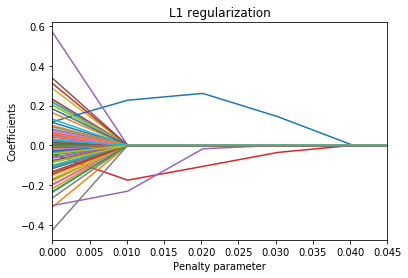

In [30]:
plt.plot(alph, all_coeffs)
plt.title('L1 regularization')
plt.ylabel('Coefficients')
plt.xlabel('Penalty parameter')
plt.xlim([0, 0.045])
plt.show()

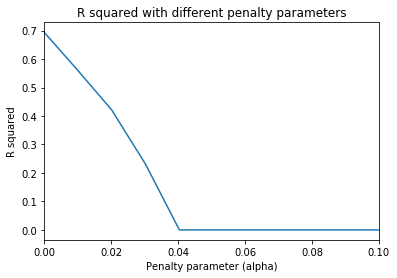

In [31]:
plt.plot(alphas, r2_scores)
plt.xlim([0, 0.1])
plt.title('R squared with different penalty parameters')
plt.xlabel('Penalty parameter (alpha)')
plt.ylabel('R squared')
plt.show()

In [32]:
# with this alpha value we have only 3 coefficients > 0:
list(alphas).index(0.01011090909090909)

8

In [33]:
# get those features which are not eliminated with alpha 0.01 (sorry for the ugly code):
pd.Series(list(df2))[[i for i in range(len(list(list(all_coeffs)[8]))) if list(list(all_coeffs)[8])[i] != 0]]

3     racePctWhite
44     PctKids2Par
50        PctIlleg
dtype: object

racePctWhite (percentage of population that is caucasian), PctKids2Par (percentage of kids in family housing with two parents), PctIlleg (percentage of kids born to never married) features still remain with penalty value higher than 0.01.

In [34]:
# L2 shrinkage:

alph = []
all_coeffs = []
r2_scores = []

for a in np.linspace(0.00001, 10, 50):
    alph.append(a)
    
    r = Ridge(alpha=a, normalize=False)
    r.fit(X_scaled, Y)
    r2_scores.append(r.score(X_scaled, Y))
    all_coeffs.append(r.coef_)

In [35]:
all_coeffs = np.array(all_coeffs)

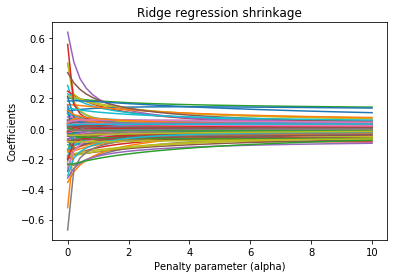

In [36]:
plt.plot(alph, all_coeffs)
plt.title('Ridge regression shrinkage')
plt.xlabel('Penalty parameter (alpha)')
plt.ylabel('Coefficients')
plt.show()

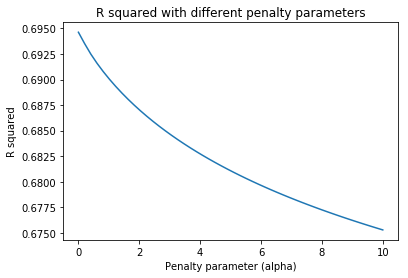

In [37]:
plt.plot(alph, r2_scores)
plt.title('R squared with different penalty parameters')
plt.xlabel('Penalty parameter (alpha)')
plt.ylabel('R squared')
plt.show()

In contrast to L1 regularization, L2 regularization did not eliminate (shrinked to 0) the coefficients. L1 regularization results in a sparse coefficient list (many zeros), while L2 regularization just shrinks the coefficients close to zero (because there is a squared term in its equation).

### 4. Subset selection

In [35]:
# Split data:
X_train = X_scaled[::2] # for me it seems, that better to use 
Y_train = Y[::2] #        scaled/normalized data for Ridge, ElasticNet, and maybe for Lasso too
X_test = X_scaled[1::2]
Y_test = Y[1::2]

In [36]:
# set up 3 different models:
ridge = RidgeCV(alphas=np.linspace(0.0001, 1, 10), cv=5)
lasso = LassoCV(alphas=np.linspace(0.0001, 1, 10), cv=5)
elastic_net = ElasticNetCV(alphas=np.linspace(0.0001, 1, 10), cv=5)

In [37]:
# set up RFEs, select always 10 features:
selector1 = RFE(ridge, step=1, n_features_to_select=10).fit(X_train, Y_train)
selector2 = RFE(lasso, step=1, n_features_to_select=10).fit(X_train, Y_train)
selector3 = RFE(elastic_net, step=1, n_features_to_select=10).fit(X_train, Y_train)

In [38]:
len([i for i in list(selector1.support_) if i == True])

10

In [39]:
print('Indices of selected features in Ridge regression: {}'.format(np.where(selector1.ranking_ == 1)))
print('Indices of selected features in Lasso regression: {}'.format(np.where(selector2.ranking_ == 1)))
print('Indices of selected features in ElasticNet model: {}'.format(np.where(selector3.ranking_ == 1)))

Indices of selected features in Ridge regression: (array([ 2, 13, 15, 31, 38, 40, 44, 50, 68, 96]),)
Indices of selected features in Lasso regression: (array([ 2, 38, 44, 45, 48, 50, 64, 69, 90, 96]),)
Indices of selected features in ElasticNet model: (array([ 2, 38, 40, 44, 45, 48, 50, 64, 69, 90]),)


As we can see, the 3 different models did not give the same features (as most important ones), but there is some overlap.

In [40]:
# get the features' actual names:
ridge_names = [list(df2)[i] for i in list(np.where(selector1.ranking_ == 1))[0]]
lasso_names = [list(df2)[i] for i in list(np.where(selector2.ranking_ == 1))[0]]
elasticn_names = [list(df2)[i] for i in list(np.where(selector3.ranking_ == 1))[0]]

In [41]:
print('Ridge regression most important 10 features: {}\n'.format(ridge_names))
print('Lasso regression most important 10 features: {}\n'.format(lasso_names))
print('Elastic Net most important 10 features: {}\n'.format(elasticn_names))

Ridge regression most important 10 features: ['racepctblack', 'pctWWage', 'pctWInvInc', 'PctBSorMore', 'MalePctDivorce', 'FemalePctDiv', 'PctKids2Par', 'PctIlleg', 'PctPersDenseHous', 'LandArea']

Lasso regression most important 10 features: ['racepctblack', 'MalePctDivorce', 'PctKids2Par', 'PctYoungKids2Par', 'PctWorkMom', 'PctIlleg', 'PersPerOccupHous', 'PctHousLess3BR', 'NumStreet', 'LandArea']

Elastic Net most important 10 features: ['racepctblack', 'MalePctDivorce', 'FemalePctDiv', 'PctKids2Par', 'PctYoungKids2Par', 'PctWorkMom', 'PctIlleg', 'PersPerOccupHous', 'PctHousLess3BR', 'NumStreet']



Most important features are for example: percentage of population that is african american, percentage of households with wage or salary income in 1989 - Ridge regression; percentage of population that is african american, percentage of males who are divorced - Lasso regression; percentage of population that is african american, percentage of males who are divorced, percentage of females who are divorced - Elastic Net.

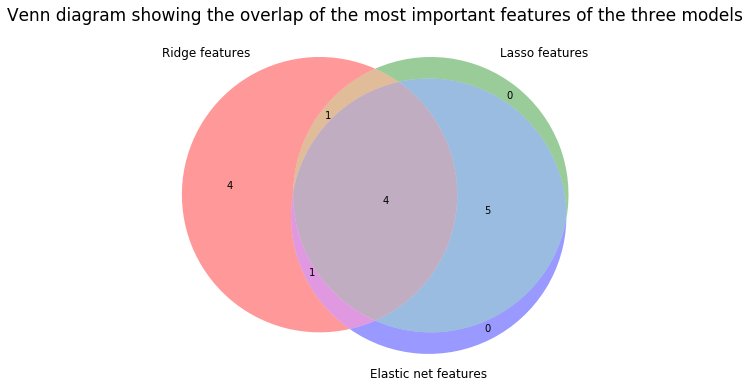

In [42]:
set1 = set(ridge_names)
set2 = set(lasso_names)
set3 = set(elasticn_names)

plt.figure(figsize=(8, 8))
venn3([set1, set2, set3], ('Ridge features', 'Lasso features', 'Elastic net features'))
plt.title('Venn diagram showing the overlap of the most important features of the three models',
         size=17)
plt.show()

In [43]:
# Create train, test data with only those 10 selected features:
X_train_ridge = X_train[:,list(np.where(selector1.ranking_ == 1)[0])]
X_test_ridge = X_test[:,list(np.where(selector1.ranking_ == 1)[0])]

X_train_lasso = X_train[:,list(np.where(selector2.ranking_ == 1)[0])]
X_test_lasso = X_test[:,list(np.where(selector2.ranking_ == 1)[0])]

X_train_elasticn = X_train[:,list(np.where(selector3.ranking_ == 1)[0])]
X_test_elasticn = X_test[:,list(np.where(selector3.ranking_ == 1)[0])]

Test the three different models on the test data (only the selected features are included):

In [44]:
ridge = Ridge(alpha=1, random_state=1)
ridge.fit(X_train_ridge, Y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001)

In [45]:
ridge.score(X_test_ridge, Y_test)

0.6257800917171695

In [46]:
lasso = Lasso(random_state=1, alpha=0.00001)
lasso.fit(X_train_ridge, Y_train)

Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)

In [47]:
lasso.score(X_train_ridge, Y_train)

0.6441777742919945

In [48]:
elastic = ElasticNet(random_state=1, normalize=True, alpha=0.0001)
elastic.fit(X_train_elasticn, Y_train)

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=True, positive=False, precompute=False,
      random_state=1, selection='cyclic', tol=0.0001, warm_start=False)

In [49]:
elastic.score(X_test_elasticn, Y_test)

0.6349881496752564

It seems that for now, the Lasso regression performs the best (however, some hypermarapeter tuning may change the performances).

In [50]:
elasticn_residuals = Y_test - elastic.predict(X_test_elasticn)
ridge_residuals = Y_test - ridge.predict(X_test_ridge)
lasso_residuals = Y_test - lasso.predict(X_test_lasso)

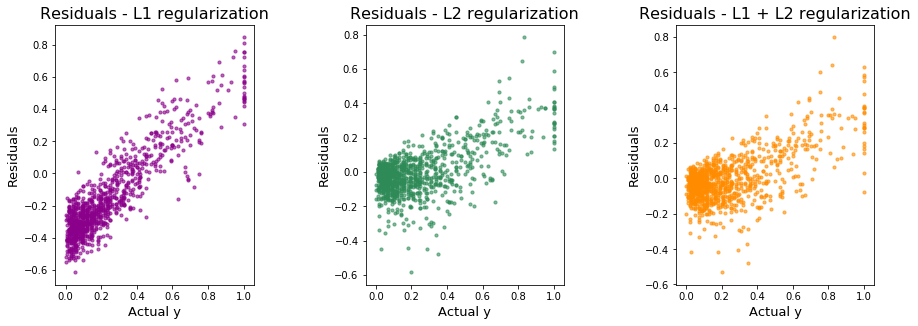

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))
ax[0].scatter(Y_test, lasso_residuals, color='darkmagenta', s=10, alpha=0.6)
ax[0].axes.set_title('Residuals - L1 regularization',fontsize=16)
ax[0].set_xlabel('Actual y',fontsize=13)
ax[0].set_ylabel('Residuals',fontsize=13)

ax[1].scatter(Y_test, ridge_residuals, color='seagreen', s=10, alpha=0.6)
ax[1].axes.set_title('Residuals - L2 regularization',fontsize=16)
ax[1].set_ylabel('Residuals',fontsize=13)
ax[1].set_xlabel('Actual y',fontsize=13)

ax[2].scatter(Y_test, elasticn_residuals, color='darkorange', s=10, alpha=0.6)
ax[2].axes.set_title('Residuals - L1 + L2 regularization',fontsize=16)
ax[2].set_ylabel('Residuals',fontsize=13)
ax[2].set_xlabel('Actual y',fontsize=13)

fig.tight_layout(pad=6.0)
plt.show()

From these plots it seems, thath L2 and L1 + L2 regularization performs the best.

### 5. ElasticNet penalty surface

In [52]:
# Calculate MAE (from the example notebook):
def get_mae_for_alpha(alpha, l1_ratio):
    en = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    en.fit(X_train, Y_train)
    en_pred = en.predict(X_test)
    return np.absolute((en_pred - Y_test)).mean()

In [53]:
# Shrinkage with different alpha, L1 ratio parameters:
alphas = []
l1_ratios = []
maes   = []

for a, l in zip(np.linspace(0.0001, 3, 50), np.linspace(0.0001, 0.9999, 50)):
    alphas.append(a)
    l1_ratios.append(l)
    maes.append(get_mae_for_alpha(a, l))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [54]:
# this is needed, because the scores are in a 1D array:
def symmetricize(arr1D):
    ID = np.arange(arr1D.size)
    return arr1D[np.abs(ID - ID[:,None])]

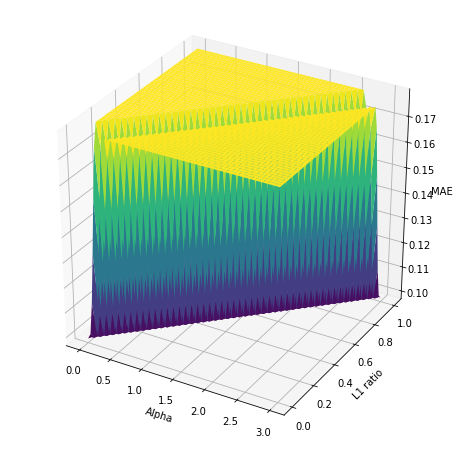

In [55]:
# Plot hyperparameter surface:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
X,Y = np.meshgrid(alphas, l1_ratios)
Z = symmetricize(np.asanyarray(maes))
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('Alpha')
ax.set_ylabel('L1 ratio')
ax.set_zlabel('MAE');

Or using ElasticNetCV for hyperparameter optimization:

In [56]:
model = ElasticNetCV(l1_ratio=np.linspace(0, 1, 50), alphas=np.linspace(0.0001, 10, 50), cv=5, n_jobs=-1)

In [57]:
model.fit(X_train, Y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wan

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/lib/python3.6

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/lib/python3.6

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/lib/python3.6

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/lib/python3.6

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/lib/python3.6

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause prec

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/lib/python3.6

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6

ElasticNetCV(alphas=array([1.00000e-04, 2.04180e-01, 4.08259e-01, 6.12339e-01, 8.16418e-01,
       1.02050e+00, 1.22458e+00, 1.42866e+00, 1.63274e+00, 1.83682e+00,
       2.04090e+00, 2.24498e+00, 2.44906e+00, 2.65313e+00, 2.85721e+00,
       3.06129e+00, 3.26537e+00, 3.46945e+00, 3.67353e+00, 3.87761e+00,
     ..., 8.77552e+00, 8.97960e+00,
       9.18368e+00, 9.38776e+00, 9.59184e+00, 9.79592e+00, 1.00000e+01]),
       copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=array([0.     , 0.02041, 0.04082, 0.06122, 0.08163, 0.10204, 0.12245,
       0.14286, 0.16327, 0.18367, 0.20408, 0.22449, 0.2449 , 0.26531,
       0.28571, 0.30612, 0.32653, 0.34694, 0.36735, 0.38776, 0.40816,
       0.42857, 0.44898, 0.46939, 0.4898 , 0.5102 , 0.53061, 0.55102,
       0.57...633, 0.83673,
       0.85714, 0.87755, 0.89796, 0.91837, 0.93878, 0.95918, 0.97959,
       1.     ]),
       max_iter=1000, n_alphas=100, n_jobs=-1, normalize=False,
       positive=False, precompute='auto', random_

In [58]:
print('alpha: %f' % model.alpha_)
print('l1_ratio_: %f' % model.l1_ratio_)

alpha: 0.000100
l1_ratio_: 0.816327


Alpha 0.0001 and L1 ratio 0.816327 hyperparameters minimizes the objective(alpha, beta) in my model. <br>
I guess for this dataset some non-linear models would perform better.